In [17]:
# Snakes_data Dataset – Data Preprocessing steps

# import Librarys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import os
import csv
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.preprocessing import image
from sklearn.decomposition import PCA
from PIL import Image
from google.colab import drive
from google.colab import files
from sklearn.utils import class_weight
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [2]:
# Load the data set and unzip it.
drive.mount('/content/drive')

import zipfile
zip_path = '/content/drive/MyDrive/Data_Snakes.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

print("Dataset extracted successfully!")

Mounted at /content/drive
Dataset extracted successfully!


In [3]:
# step 1
# member 3 (Data Cleaning)
# Remove curropt and unreadable images

train_all_path = '/content/Data_Snakes/train_all'
test_path = '/content/Data_Snakes/test'

def check_images(directory):
    corrupt_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(root, file)
                try:
                    img = Image.open(path)
                    img.verify()
                    img = Image.open(path)
                    img.load()
                except Exception as e:
                    corrupt_paths.append(path)
                    print(f"Removing corrupt file: {path}")
                    os.remove(path)
    return corrupt_paths

corrupt_files = check_images(train_all_path)
print(f"\nData Cleaning Complete. Removed {len(corrupt_files)} corrupt files.")

Removing corrupt file: /content/Data_Snakes/train_all/venomous/empty_image.jpg

Data Cleaning Complete. Removed 1 corrupt files.


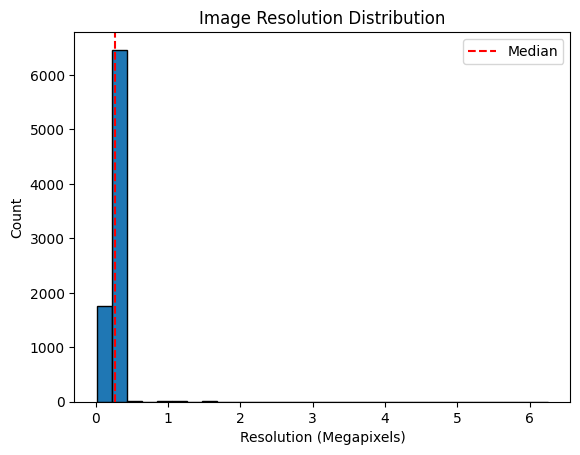

In [4]:
# EDA visualization -  Histrogram for Distribution of image resolutions

os.makedirs("results/eda_visualizations", exist_ok=True)

sizes = []
for root, _, files in os.walk(train_all_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            with Image.open(os.path.join(root, file)) as img:
                sizes.append(img.size)

df = pd.DataFrame(sizes, columns=["Width", "Height"])
df["MP"] = (df["Width"] * df["Height"]) / 1e6

plt.hist(df["MP"], bins=30, edgecolor="black")
plt.axvline(df["MP"].median(), color="red", linestyle="--", label="Median")
plt.xlabel("Resolution (Megapixels)")
plt.ylabel("Count")
plt.title("Image Resolution Distribution")
plt.legend()

# save the plot as a png
plt.savefig("results/eda_visualizations/image_resolution_distribution.png", dpi=300)
plt.show()

In [5]:
# step 2
# member 1 (Handling class imbalance)
# Count images per class and compute class weights


venomous_path = os.path.join(train_all_path, "venomous")
nonvenomous_path = os.path.join(train_all_path, "nonVenom")

num_venomous = len(os.listdir(venomous_path))
num_nonVenomous = len(os.listdir(nonvenomous_path))

print(f"Venomous images: {num_venomous}")
print(f"Non-venomous images: {num_nonVenomous}")

# Compute class weights
y_labels = np.array([0] * num_nonVenomous + [1] * num_venomous)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_labels),
    y=y_labels
)

print("Class Weights:", dict(enumerate(weights)))


Venomous images: 4140
Non-venomous images: 4140
Class Weights: {0: np.float64(1.0), 1: np.float64(1.0)}


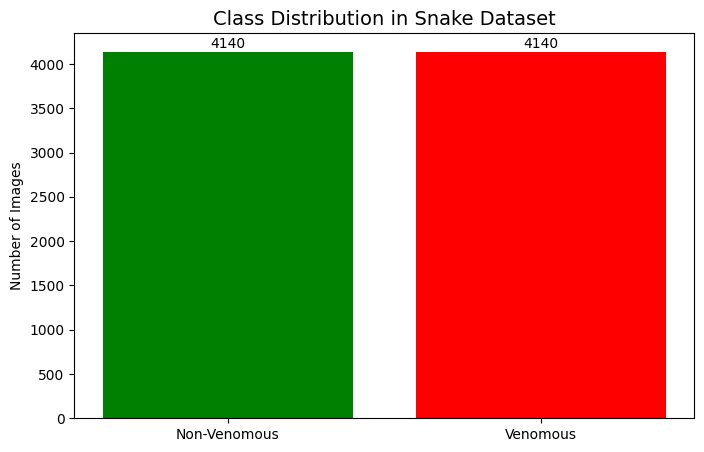

In [6]:
# EDA visualization - Bar chart for class weight distribution

os.makedirs("results/eda_visualizations", exist_ok=True)

plt.figure(figsize=(8, 5))
classes = ['Non-Venomous', 'Venomous']
counts = [num_nonVenomous, num_venomous]
colors = ['green', 'red']

plt.bar(classes, counts, color=colors)
plt.title('Class Distribution in Snake Dataset', fontsize=14)
plt.ylabel('Number of Images')
for i, count in enumerate(counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

# Save as PNG
plt.savefig("results/eda_visualizations/class_distribution.png", dpi=300)
plt.show()

In [7]:
# step 3
# member 2 (Label encoding)
# Convert class names to numerical values 1 and 0

generator = ImageDataGenerator().flow_from_directory(
    train_all_path,
    classes=['nonVenom', 'venomous'],
    class_mode='binary',
    shuffle=False
)

print("Class indices:", generator.class_indices)

Found 8280 images belonging to 2 classes.
Class indices: {'nonVenom': 0, 'venomous': 1}


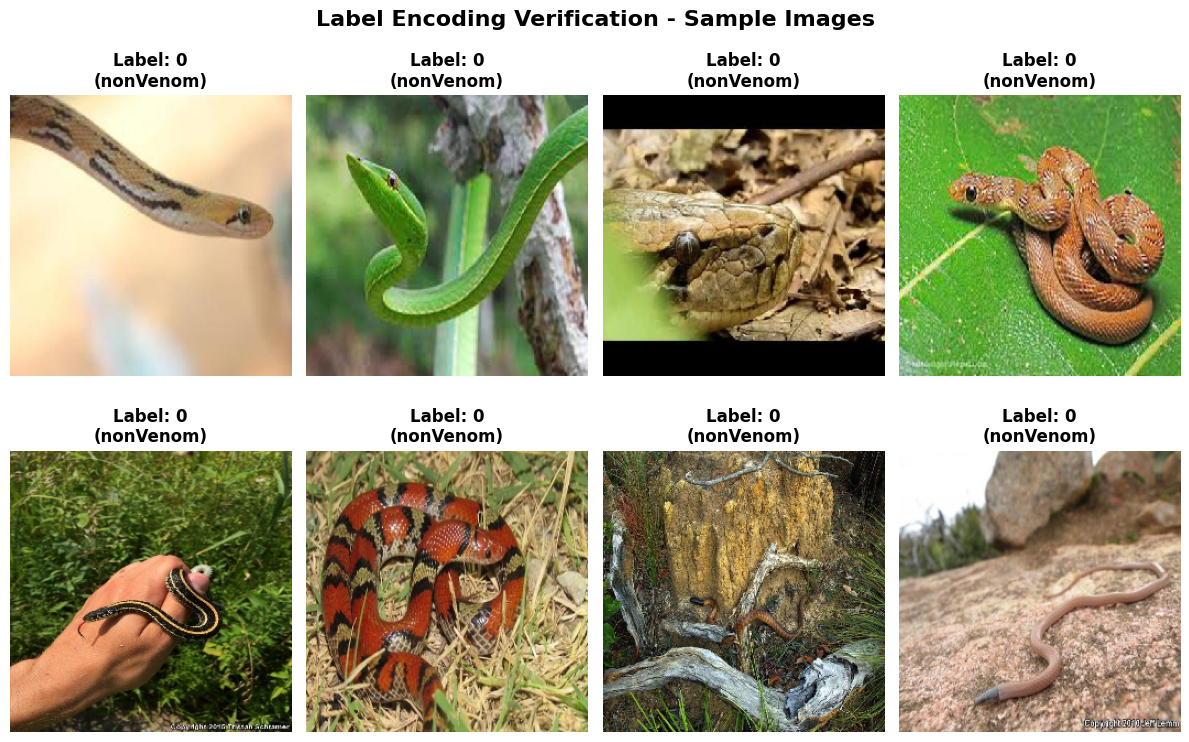

In [8]:
# EDA visualization- Label encoing verification

os.makedirs("results/eda_visualizations", exist_ok=True)

sample_images, sample_labels = next(generator)
idx_to_class = {v: k for k, v in generator.class_indices.items()}

plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(sample_images[i].astype('uint8'))  # cast to 0-255 integers
    label = int(sample_labels[i])
    class_name = idx_to_class[label]
    plt.title(f"Label: {label}\n({class_name})", fontweight='bold')
    plt.axis('off')

plt.suptitle('Label Encoding Verification - Sample Images', fontsize=16, fontweight='bold')
plt.tight_layout()

# Save as PNG
plt.savefig("results/eda_visualizations/label_encoding_verification.png", dpi=300)
plt.show()

In [9]:
# step 4
# member 4 (Normalization & Resizing Confirmation)
# Verify pixel scaling [0,255] -> [0,1] and resizing

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    train_all_path,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=False
)

val_gen = datagen.flow_from_directory(
    train_all_path,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Test generator (rescale only)
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

images_batch, labels_batch = next(train_gen)

print(f"Batch Shape (Images): {images_batch.shape}")
print(f"Data Type (Images): {images_batch.dtype}")
print(f"Min Pixel Value: {images_batch.min():.3f}")
print(f"Max Pixel Value: {images_batch.max():.3f}")

print(f"Label of first image: {labels_batch[0]}")

Found 6624 images belonging to 2 classes.
Found 1656 images belonging to 2 classes.
Found 921 images belonging to 2 classes.
Batch Shape (Images): (32, 150, 150, 3)
Data Type (Images): float32
Min Pixel Value: 0.000
Max Pixel Value: 1.000
Label of first image: 0.0


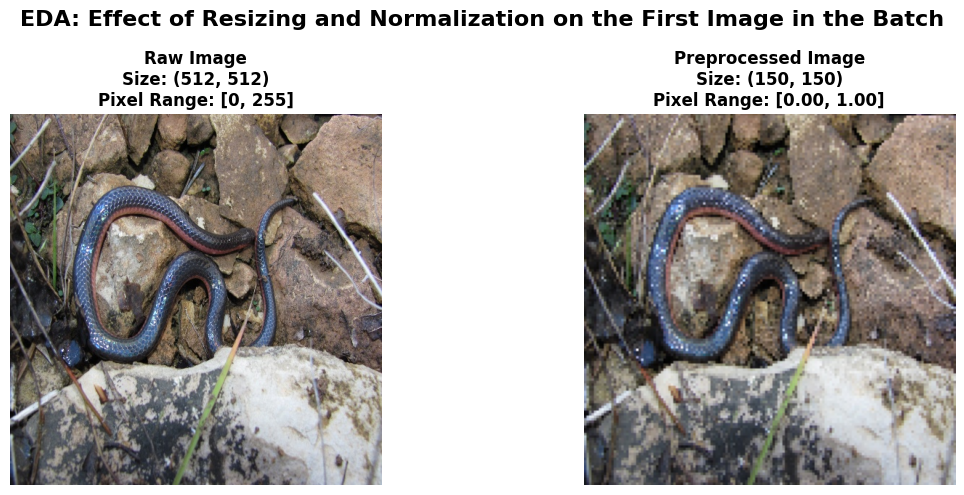

In [10]:
# EDA visualization - Effect of Resizing and Normalization on the First Image in the Batch

os.makedirs("results/eda_visualizations", exist_ok=True)

first_file_path = train_gen.filepaths[0]
raw_img = image.load_img(first_file_path)
raw_img_array = image.img_to_array(raw_img)

preprocessed_img = images_batch[0]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(raw_img_array.astype('uint8'))
axes[0].set_title(f'Raw Image\nSize: {raw_img_array.shape[:-1]}\nPixel Range: [0, 255]', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(preprocessed_img)
axes[1].set_title(f'Preprocessed Image\nSize: {preprocessed_img.shape[:-1]}\nPixel Range: [{preprocessed_img.min():.2f}, {preprocessed_img.max():.2f}]', fontweight='bold')
axes[1].axis('off')

plt.suptitle('EDA: Effect of Resizing and Normalization on the First Image in the Batch', fontsize=16, fontweight='bold')
plt.tight_layout()

# Save as PNG
plt.savefig("results/eda_visualizations/effect_resizing_normalization.png", dpi=300)
plt.show()

In [11]:
# step 5
# member 5 (Data Augmentation)
# Create synthetic images with rotations, flips, zoom, etc.

img_path = '/content/Data_Snakes/train_all/venomous/Image_venom_001.jpg'
img = load_img(img_path, target_size=(150, 150))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

aug_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)

aug_iterator = aug_gen.flow(img_array, batch_size=1)

augmented_images = [next(aug_iterator)[0] for _ in range(8)]
print("Augmented images created successfully!")

Augmented images created successfully!


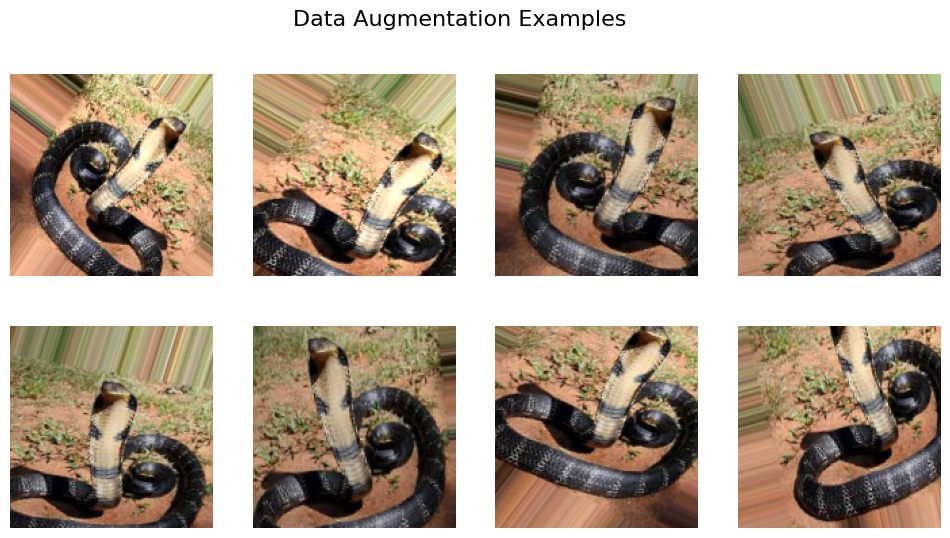

In [12]:
# EDA visualization - Examples for Data Augmentation

os.makedirs("results/eda_visualizations", exist_ok=True)

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.suptitle("Data Augmentation Examples", fontsize=16)

# Save figure
plt.savefig("results/eda_visualizations/data_augmentation_examples.png", dpi=300)
plt.show()

In [13]:
# step 6
# member 6 (Feature Extraction & Dimensionality Reduction)
# Extract CNN features and visualize with PCA

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

sample_batch, labels_batch = next(train_gen)
print(f"Input batch shape: {sample_batch.shape}")

extracted_features = feature_extractor.predict(sample_batch)
print(f"Extracted features shape: {extracted_features.shape}")

flattened_features = extracted_features.reshape(extracted_features.shape[0], -1)
print(f"Flattened features shape: {flattened_features.shape}")
print(f"Dimensionality reduced from {sample_batch[0].size} to {flattened_features[0].size} per image.")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Input batch shape: (32, 150, 150, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Extracted features shape: (32, 4, 4, 512)
Flattened features shape: (32, 8192)
Dimensionality reduced from 67500 to 8192 per image.


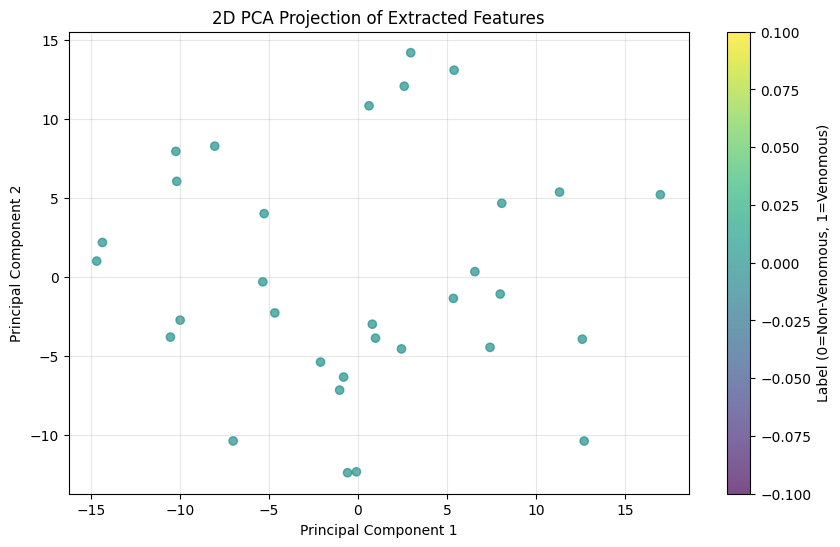

In [14]:
# EDA visualization - Performs of PCA

os.makedirs("results/eda_visualizations", exist_ok=True)

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(flattened_features)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1],
                      c=labels_batch, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Label (0=Non-Venomous, 1=Venomous)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Projection of Extracted Features')
plt.grid(True, alpha=0.3)

# Save as png
plt.savefig("results/eda_visualizations/pca_2d_projection.png", dpi=300)
plt.show()

In [15]:

# Save preprocessed data
classes = ["nonVenom", "venomous"]
output_dir = "/content/Data_Snakes_processed_jpg"
os.makedirs(output_dir, exist_ok=True)

# Make folders for each class
for cls in classes:
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)

# CSV file to save mappings
csv_path = os.path.join(output_dir, "labels.csv")

with open(csv_path, mode="w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["filename", "label"])

    for label, cls in enumerate(classes):
        input_path = os.path.join(train_all_path, cls)

        for idx, file in enumerate(os.listdir(input_path)):
            try:
                # Load and resize only
                img = load_img(os.path.join(input_path, file), target_size=(150, 150))
                img_out = img.convert("RGB")

                # Save as JPG
                filename = f"{cls}_{idx}.jpg"
                save_path = os.path.join(output_dir, cls, filename)
                img_out.save(save_path, "JPEG")

                # Write filename and label to CSV
                writer.writerow([f"{cls}/{filename}", label])

            except Exception as e:
                print(f"Skipping {file}: {e}")
                continue

print(f"✅ Processed images saved in: {output_dir}")
print(f"✅ Labels saved in: {csv_path}")


✅ Processed images saved in: /content/Data_Snakes_processed_jpg
✅ Labels saved in: /content/Data_Snakes_processed_jpg/labels.csv


In [18]:
# Saved dataset as a zip in device
!zip -r /content/Data_Snakes_processed_jpg.zip /content/Data_Snakes_processed_jpg
files.download("/content/Data_Snakes_processed_jpg.zip")


Streaming output truncated to the last 5000 lines.
updating: content/Data_Snakes_processed_jpg/venomous/venomous_14.jpg (deflated 2%)
updating: content/Data_Snakes_processed_jpg/venomous/venomous_4118.jpg (deflated 2%)
updating: content/Data_Snakes_processed_jpg/venomous/venomous_3463.jpg (deflated 2%)
updating: content/Data_Snakes_processed_jpg/venomous/venomous_727.jpg (deflated 2%)
updating: content/Data_Snakes_processed_jpg/venomous/venomous_3520.jpg (deflated 2%)
updating: content/Data_Snakes_processed_jpg/venomous/venomous_1361.jpg (deflated 4%)
updating: content/Data_Snakes_processed_jpg/venomous/venomous_4043.jpg (deflated 3%)
updating: content/Data_Snakes_processed_jpg/venomous/venomous_1403.jpg (deflated 1%)
updating: content/Data_Snakes_processed_jpg/venomous/venomous_1296.jpg (deflated 1%)
updating: content/Data_Snakes_processed_jpg/venomous/venomous_3804.jpg (deflated 2%)
updating: content/Data_Snakes_processed_jpg/venomous/venomous_3769.jpg (deflated 2%)
updating: content

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>